## Arabic viral tweets analysis - kaggle dataset - https://www.kaggle.com/datasets/fahdseddik/arabic-viral-tweets

In [2]:
##necessary imports

import pandas as pd
import matplotlib.pyplot as plt 
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.segmenter import FarasaSegmenter
import os 
import nltk
import re
import tempfile
import subprocess

pd.set_option("display.max_colwidth",None)

#### Initial data inspection

In [3]:
df = pd.read_csv("Tweets.csv",header=[0])

df.head(10)

,Date,User,Tweet,Likes,Retweets,Replies
0,2022-09-19 23:59:53+00:00,Dr_alqarnee,"🌺عبادة الأبرار، الاستغفار بالأسحار🌺\n\n""أستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه""،\n\n""أستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه""،\n\n""أستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه"".",928,768,75
1,2022-09-19 23:58:32+00:00,Ruh_Rd,لو لا لطف الله ثم يقظة سائق الحافلة لحدثت الكارثة \nسائق ينقذ طفلة من الدهس في آخر لحظة. @Nasser7g7\nمعلومة مهمة:\nتجاوز حافلات النقل المدرسي عند توقفها للتحميل أو التنزيل = 3000 ريال وتصل 6000 ريال 🔥 https://t.co/IP0IG4Iy8j,1431,1085,650
2,2022-09-19 23:58:24+00:00,nour15467,سهرانة لوحدي ومولعه من كسي احح https://t.co/TTSvM5cGf3,749,31,86
3,2022-09-19 23:57:46+00:00,Toonzatt,أجمل ما قيل في الصداقة: https://t.co/nzOznh5YqY,3868,355,168
4,2022-09-19 23:54:48+00:00,mohamedfares07,الفيلم مش هيخلص وانت مش في موضع اتهام من آي جهة. النيابة طلعت شهادة بإنك معندكش أي مخالفة وصندوق تحيا مصر في تصريحات صوت وصورة قال انك سلمت الهدايا. يبقى تجاهل تمامًا لإن دي قصة هدفها التشوية وانها تنسيك انك لو هتتكلم في حاجة يبقى الكلام عن الحكم النهائي اللي لم ينفذ لحد دلوقتي,2352,155,101
5,2022-09-19 23:53:44+00:00,Gold30Messi,الاسطورة ميسي عبر IG : https://t.co/dsM5dj2L8l,942,31,32
6,2022-09-19 23:51:52+00:00,iiml9_,يارب سيّر لنا الأشياء مثل ما نحب مثل ما نتمنى,1185,176,16
7,2022-09-19 23:51:05+00:00,egymeme11,و انا بواسي نفسي كل يوم بالليل: https://t.co/auEqfsLbye,1378,298,17
8,2022-09-19 23:50:53+00:00,my_dream__z,"""وكل شي بالدعاء آتٍ.""",1050,238,13
9,2022-09-19 23:50:37+00:00,moh_attia77,طيب عواد كتب تويتة ينفى خبر صحفى اتنشر وأكد على رغبته فى اللعب للمنتخب ومعملش حاجة غلط .. صلاح نعى ملكة انجلترا البلد اللى هو عايش فيها ومُحاط بحب وتقدير سكانها واللى شيخ الأزهر نعاها ومصر نفسها نعتها ومعملش حاجة غلط .. كل واحد حر فى مساحته الشخصية ما لم يدعو لكفر أو خيانة وطن,585,26,14


In [4]:
print("# of rows: {}\n# of columns: {}".format(df.shape[0],df.shape[1]))

# of rows: 100000
# of columns: 6


In [5]:
list(df.columns)

['Date', 'User', 'Tweet', 'Likes', 'Retweets', 'Replies']

In [6]:
for i in df.columns:
    print(df[i].dtype)
    print(type(df[i][0]))
    print("-------------------")

object
<class 'str'>
-------------------
object
<class 'str'>
-------------------
object
<class 'str'>
-------------------
int64
<class 'numpy.int64'>
-------------------
int64
<class 'numpy.int64'>
-------------------
int64
<class 'numpy.int64'>
-------------------


In [7]:
df['Date'] = pd.to_datetime(df['Date'])



In [8]:
df.isna().sum()

Date        0
User        0
Tweet       0
Likes       0
Retweets    0
Replies     0
dtype: int64

#### Regex cleaning text - keeping arabic letters only

In [9]:
def clear_tweet(tweet):
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'[a-zA-Z]', '', tweet)

    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           "]+", flags=re.UNICODE)

    tweet = emoji_pattern.sub(r'', tweet)

    return tweet
        

In [10]:
df['Cleaned_tweets'] = df['Tweet'].apply(clear_tweet)

#### White space Tokenization - Word based

In [11]:
def tokenize_tweet(tweet):
    return tweet.split()

In [12]:
df['tokenized_tweets'] = df['Cleaned_tweets'].apply(tokenize_tweet)

#### Using Farasa Segmenter

In [14]:


# farasa_segmenter = FarasaSegmenter(interactive=True)

# def segment_text(text):
#     return farasa_segmenter.segment(text)

# df['segmented_tweets'] = df['Cleaned_tweets'].apply(segment_text)


In [15]:
df.head()

,Date,User,Tweet,Likes,Retweets,Replies,Cleaned_tweets,tokenized_tweets
0,2022-09-19 23:59:53+00:00,Dr_alqarnee,"🌺عبادة الأبرار، الاستغفار بالأسحار🌺\n\n""أستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه""،\n\n""أستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه""،\n\n""أستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه"".",928,768,75,عبادة الأبرار الاستغفار بالأسحار\n\nأستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه\n\nأستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه\n\nأستغفر الله العظيم الذي لا إله إلا هو الحي القيوم وأتوب إليه,"[عبادة, الأبرار, الاستغفار, بالأسحار, أستغفر, الله, العظيم, الذي, لا, إله, إلا, هو, الحي, القيوم, وأتوب, إليه, أستغفر, الله, العظيم, الذي, لا, إله, إلا, هو, الحي, القيوم, وأتوب, إليه, أستغفر, الله, العظيم, الذي, لا, إله, إلا, هو, الحي, القيوم, وأتوب, إليه]"
1,2022-09-19 23:58:32+00:00,Ruh_Rd,لو لا لطف الله ثم يقظة سائق الحافلة لحدثت الكارثة \nسائق ينقذ طفلة من الدهس في آخر لحظة. @Nasser7g7\nمعلومة مهمة:\nتجاوز حافلات النقل المدرسي عند توقفها للتحميل أو التنزيل = 3000 ريال وتصل 6000 ريال 🔥 https://t.co/IP0IG4Iy8j,1431,1085,650,لو لا لطف الله ثم يقظة سائق الحافلة لحدثت الكارثة \nسائق ينقذ طفلة من الدهس في آخر لحظة 77\nمعلومة مهمة\nتجاوز حافلات النقل المدرسي عند توقفها للتحميل أو التنزيل 3000 ريال وتصل 6000 ريال 048,"[لو, لا, لطف, الله, ثم, يقظة, سائق, الحافلة, لحدثت, الكارثة, سائق, ينقذ, طفلة, من, الدهس, في, آخر, لحظة, 77, معلومة, مهمة, تجاوز, حافلات, النقل, المدرسي, عند, توقفها, للتحميل, أو, التنزيل, 3000, ريال, وتصل, 6000, ريال, 048]"
2,2022-09-19 23:58:24+00:00,nour15467,سهرانة لوحدي ومولعه من كسي احح https://t.co/TTSvM5cGf3,749,31,86,سهرانة لوحدي ومولعه من كسي احح 53,"[سهرانة, لوحدي, ومولعه, من, كسي, احح, 53]"
3,2022-09-19 23:57:46+00:00,Toonzatt,أجمل ما قيل في الصداقة: https://t.co/nzOznh5YqY,3868,355,168,أجمل ما قيل في الصداقة 5,"[أجمل, ما, قيل, في, الصداقة, 5]"
4,2022-09-19 23:54:48+00:00,mohamedfares07,الفيلم مش هيخلص وانت مش في موضع اتهام من آي جهة. النيابة طلعت شهادة بإنك معندكش أي مخالفة وصندوق تحيا مصر في تصريحات صوت وصورة قال انك سلمت الهدايا. يبقى تجاهل تمامًا لإن دي قصة هدفها التشوية وانها تنسيك انك لو هتتكلم في حاجة يبقى الكلام عن الحكم النهائي اللي لم ينفذ لحد دلوقتي,2352,155,101,الفيلم مش هيخلص وانت مش في موضع اتهام من آي جهة النيابة طلعت شهادة بإنك معندكش أي مخالفة وصندوق تحيا مصر في تصريحات صوت وصورة قال انك سلمت الهدايا يبقى تجاهل تماما لإن دي قصة هدفها التشوية وانها تنسيك انك لو هتتكلم في حاجة يبقى الكلام عن الحكم النهائي اللي لم ينفذ لحد دلوقتي,"[الفيلم, مش, هيخلص, وانت, مش, في, موضع, اتهام, من, آي, جهة, النيابة, طلعت, شهادة, بإنك, معندكش, أي, مخالفة, وصندوق, تحيا, مصر, في, تصريحات, صوت, وصورة, قال, انك, سلمت, الهدايا, يبقى, تجاهل, تماما, لإن, دي, قصة, هدفها, التشوية, وانها, تنسيك, انك, لو, هتتكلم, في, حاجة, يبقى, الكلام, عن, الحكم, النهائي, اللي, لم, ينفذ, لحد, دلوقتي]"


#### Wordcloud - Stop words included

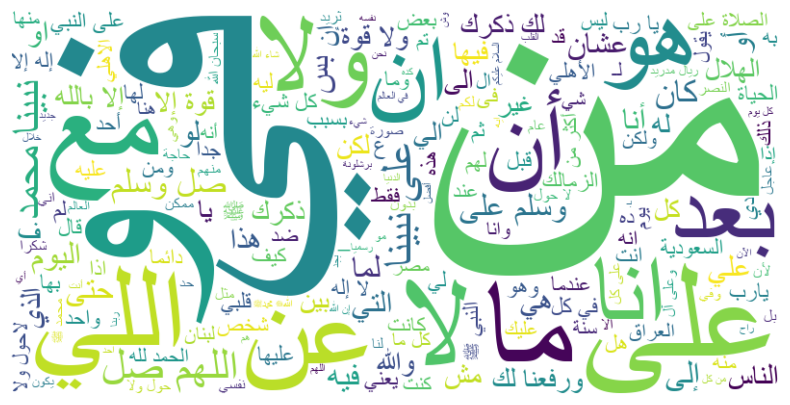

In [19]:
joined_tweets = ' '.join(df['Cleaned_tweets'])
reshaped_tweets = arabic_reshaper.reshape(joined_tweets)
bidi_edt = get_display(reshaped_tweets)

wordcloud = WordCloud(font_path='arial', width=800, height=400, background_color='white').generate(bidi_edt)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()